In [15]:
import os
import cv2
import numpy as np
import yaml
import joblib
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imutils.object_detection import non_max_suppression
import selectivesearch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ===============================
# Paths and HOG
# ===============================
BASE_PATH = "archive"
TRAIN_IMG_DIR = os.path.join(BASE_PATH, "train", "images")
TRAIN_LBL_DIR = os.path.join(BASE_PATH, "train", "labels")
VALID_IMG_DIR = os.path.join(BASE_PATH, "valid", "images")
TEST_IMG_DIR = os.path.join(BASE_PATH, "test", "images")
TEST_LBL_DIR = os.path.join(BASE_PATH, "test", "labels")

HOG_WINDOW_SIZE = (64, 64)
HOG = cv2.HOGDescriptor(HOG_WINDOW_SIZE, (16,16), (8,8), (8,8), 9)

# Load class info
with open(os.path.join(BASE_PATH, "data.yaml"), "r") as f:
    data_cfg = yaml.safe_load(f)
CLASS_NAMES = data_cfg["names"]
NUM_CLASSES = data_cfg["nc"]
print(f"Loaded {NUM_CLASSES} classes: {CLASS_NAMES}")

# ===============================
# Helper functions
# ===============================
def convert_yolo_to_pixels(yolo_box, img_width, img_height):
    x_center, y_center, w, h = yolo_box
    x_center_px = x_center * img_width
    y_center_px = y_center * img_height
    width_px = w * img_width
    height_px = h * img_height
    x1 = int(x_center_px - width_px / 2)
    y1 = int(y_center_px - height_px / 2)
    x2 = int(x_center_px + width_px / 2)
    y2 = int(y_center_px + height_px / 2)
    return max(0, x1), max(0, y1), min(img_width, x2), min(img_height, y2)

def extract_hog_features(images):
    feats = []
    for img in tqdm(images, desc="Extracting HOG"):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        feats.append(HOG.compute(gray).flatten())
    return np.array(feats)

# ===============================
# Training HOG + RF
# ===============================
def train_rf(sample_size=3000, random_state=42, save_path="rf_model_insect.pkl", whole_image=False):
    img_files = [f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith('.jpg')]
    np.random.seed(random_state)
    selected_files = np.random.choice(img_files, size=min(sample_size, len(img_files)), replace=False)

    X, y = [], []
    for img_file in tqdm(selected_files, desc="Loading images and labels"):
        img_path = os.path.join(TRAIN_IMG_DIR, img_file)
        lbl_path = os.path.join(TRAIN_LBL_DIR, os.path.splitext(img_file)[0] + ".txt")
        if not os.path.exists(lbl_path):
            continue
        img = cv2.imread(img_path)
        img_h, img_w = img.shape[:2]

        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                class_id = int(parts[0])
                if whole_image:
                    X.append(cv2.resize(img, HOG_WINDOW_SIZE))
                    y.append(class_id)
                else:
                    bbox = [float(x) for x in parts[1:5]]
                    x1, y1, x2, y2 = convert_yolo_to_pixels(bbox, img_w, img_h)
                    cropped = img[y1:y2, x1:x2]
                    if cropped.size == 0:
                        continue
                    X.append(cv2.resize(cropped, HOG_WINDOW_SIZE))
                    y.append(class_id)

    print(f"Loaded {len(X)} samples for training.")
    X_feats = extract_hog_features(X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_feats)

    rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=random_state)
    rf.fit(X_scaled, y)
    print("Random Forest training completed.")

    joblib.dump({"model": rf, "scaler": scaler, "class_names": CLASS_NAMES}, save_path)
    print(f"Model saved to {save_path}")

# ===============================
# Detection (一次加载模型)
# ===============================
def detect_image_rf(test_img, rf_model, scaler, class_names,
                    show_plots=True, show_grams=False, nms_iou_thresh=0.6, IoU_THRESHOLD=0.5):
    img_path = os.path.join(TEST_IMG_DIR, test_img)
    lbl_path = os.path.join(TEST_LBL_DIR, os.path.splitext(test_img)[0] + ".txt")
    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    # Whole image classification
    resized = cv2.resize(img, HOG_WINDOW_SIZE)
    feat = HOG.compute(cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)).flatten().reshape(1, -1)
    feat_scaled = scaler.transform(feat)
    probs = rf_model.predict_proba(feat_scaled)[0]
    whole_img_pred_cls = np.argmax(probs)
    whole_img_prob = probs[whole_img_pred_cls]

    if show_plots:
        print(f"Predicted class: {class_names[whole_img_pred_cls]} (prob: {whole_img_prob:.6f})")
    # Ground truth boxes
    gt_boxes = []
    if os.path.exists(lbl_path):
        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                class_id = int(parts[0])
                bbox = [float(x) for x in parts[1:5]]
                x1, y1, x2, y2 = convert_yolo_to_pixels(bbox, img_w, img_h)
                gt_boxes.append((x1, y1, x2, y2, class_id))

    # Selective search proposals
    _, regions = selectivesearch.selective_search(img, scale=500, sigma=0.9, min_size=10)
    proposals = []
    for r in regions:
        x, y, w, h = r['rect']
        if r['size'] < 2000 or w > img_w*0.98 or h > img_h*0.98:
            continue
        proposals.append(r['rect'])

    # Predict each proposal
    boxes, probs_list, pred_classes = [], [], []
    for (x, y, w, h) in proposals:
        cropped = img[y:y+h, x:x+w]
        if cropped.size == 0:
            continue
        resized_crop = cv2.resize(cropped, HOG_WINDOW_SIZE)
        feat = HOG.compute(cv2.cvtColor(resized_crop, cv2.COLOR_BGR2GRAY)).flatten().reshape(1, -1)
        feat_scaled = scaler.transform(feat)
        prob_vector = rf_model.predict_proba(feat_scaled)[0]
        pred_cls = np.argmax(prob_vector)

        boxes.append([x, y, x+w, y+h])
        probs_list.append(prob_vector[pred_cls])
        pred_classes.append(pred_cls)

    if len(boxes) == 0:
        return 0, 0, len(gt_boxes)

    boxes = np.array(boxes)
    probs_list = np.array(probs_list)

    # NMS
    nms_boxes = non_max_suppression(boxes, probs=probs_list, overlapThresh=nms_iou_thresh)
    nms_classes = []
    for nb in nms_boxes:
        for i, b in enumerate(boxes):
            if np.all(nb == b):
                nms_classes.append(pred_classes[i])
                break
    # visualize proposals
    if show_grams:
        img_proposals = img.copy()
        for (x, y, w, h) in proposals:
            cv2.rectangle(img_proposals, (x, y), (x+w, y+h), (0,255,0), 1)
        plt.figure(figsize=(10,6))
        plt.imshow(cv2.cvtColor(img_proposals, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Selective Search Proposals")
        plt.show()
    # visualize NMS results
    if show_grams:
        img_nms = img.copy()
        for (x1, y1, x2, y2) in nms_boxes:
            cv2.rectangle(img_nms, (x1, y1), (x2, y2), (255,0,0), 2)
        plt.figure(figsize=(10,6))
        plt.imshow(cv2.cvtColor(img_nms, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("NMS on Proposals")
        plt.show()

    # Compute TP, FP, FN
    tp, fp = 0, 0
    for i, box in enumerate(nms_boxes):
        matched = False
        for gx1, gy1, gx2, gy2, gclass in gt_boxes:
            ix1 = max(box[0], gx1)
            iy1 = max(box[1], gy1)
            ix2 = min(box[2], gx2)
            iy2 = min(box[3], gy2)
            iw = max(0, ix2 - ix1)
            ih = max(0, iy2 - iy1)
            inter_area = iw * ih
            union_area = (box[2]-box[0])*(box[3]-box[1]) + (gx2-gx1)*(gy2-gy1) - inter_area
            iou = inter_area / union_area if union_area > 0 else 0
            if iou >= IoU_THRESHOLD and nms_classes[i] == gclass:
                matched = True
                break
        if matched:
            tp += 1
        else:
            fp += 1
    fn = max(len(gt_boxes) - tp, 0)

    return tp, fp, fn

# ===============================
# Evaluate mAP
# ===============================
def evaluate_mAP_rf(model_path="rf_model_insect.pkl", IoU_thresholds=[0.1,0.3,0.5,0.7,0.9]):
    # ===== load model =====
    model_data = joblib.load(model_path)
    rf = model_data["model"]
    scaler = model_data["scaler"]
    class_names = model_data["class_names"]
    NUM_CLASSES = len(class_names)

    test_img_files = [f for f in os.listdir(TEST_IMG_DIR)
                      if f.lower().endswith(('.jpg','.png','.jpeg'))]
    if not test_img_files:
        print("No test images found.")
        return 0, []

    # ===== Step 1: Generate proposals & predictions =====
    all_preds = {}  # 每张图: boxes, pred_classes, pred_probs, gt_boxes
    for img_file in tqdm(test_img_files, desc="Generating proposals & predictions"):
        img_path = os.path.join(TEST_IMG_DIR, img_file)
        lbl_path = os.path.join(TEST_LBL_DIR, os.path.splitext(img_file)[0]+".txt")
        img = cv2.imread(img_path)
        img_h, img_w = img.shape[:2]

        # selective search
        _, regions = selectivesearch.selective_search(img, scale=500, sigma=0.9, min_size=10)
        proposals = []
        for r in regions:
            x, y, w, h = r['rect']
            if r['size'] < 2000 or w>img_w*0.98 or h>img_h*0.98:
                continue
            proposals.append([x, y, x+w, y+h])

        if len(proposals)==0:
            all_preds[img_file] = {"boxes": np.array([]), "pred_classes": np.array([]),
                                   "pred_probs": np.array([]), "gt_boxes": []}
            continue

        # 批量提取 HOG
        crops = []
        for (x1,y1,x2,y2) in proposals:
            crop = img[y1:y2, x1:x2]
            if crop.size==0: crop = np.zeros((64,64,3), dtype=np.uint8)
            crops.append(cv2.resize(crop,(64,64)))
        feats = np.array([HOG.compute(cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)).flatten() for c in crops])
        feats_scaled = scaler.transform(feats)
        probs = rf.predict_proba(feats_scaled)
        pred_classes = np.argmax(probs, axis=1)
        pred_probs = probs[np.arange(len(probs)), pred_classes]

        # GT boxes
        gt_boxes = []
        if os.path.exists(lbl_path):
            with open(lbl_path,"r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts: continue
                    class_id = int(parts[0])
                    bbox = [float(x) for x in parts[1:5]]
                    x1,y1,x2,y2 = convert_yolo_to_pixels(bbox,img_w,img_h)
                    gt_boxes.append((x1,y1,x2,y2,class_id))

        all_preds[img_file] = {"boxes": np.array(proposals), "pred_classes": pred_classes,
                               "pred_probs": pred_probs, "gt_boxes": gt_boxes}

    # ===== Step 2: compute AP per class =====
    APs = []
    print("===== Computing AP for each class =====")
    for class_idx in range(NUM_CLASSES):
        class_name = class_names[class_idx]
        AP_per_IoU = []
    
        for IoU_T in IoU_thresholds:
            # 收集该类别所有预测
            pred_list = []
            num_gt = 0
            for img_file in test_img_files:
                data = all_preds[img_file]
                boxes, pred_classes, pred_probs, gt_boxes = data["boxes"], data["pred_classes"], data["pred_probs"], data["gt_boxes"]
                # GT count
                num_gt += sum([1 for g in gt_boxes if g[4]==class_idx])
                # 预测
                for i, cls in enumerate(pred_classes):
                    if cls == class_idx:
                        pred_list.append((img_file, boxes[i], pred_probs[i]))
    
            if len(pred_list) == 0:
                AP_per_IoU.append(0)
                continue

            # 按置信度排序
            pred_list.sort(key=lambda x: x[2], reverse=True)
            tp, fp = np.zeros(len(pred_list)), np.zeros(len(pred_list))
            matched_gt_dict = {f: [] for f in test_img_files}
    
            for i, (img_file, box, prob) in enumerate(pred_list):
                gt_boxes = all_preds[img_file]["gt_boxes"]
                max_iou = 0
                matched_gt = -1
                for j, (gx1,gy1,gx2,gy2,gclass) in enumerate(gt_boxes):
                    if gclass != class_idx or j in matched_gt_dict[img_file]:
                        continue
                    ix1 = max(box[0], gx1)
                    iy1 = max(box[1], gy1)
                    ix2 = min(box[2], gx2)
                    iy2 = min(box[3], gy2)
                    iw = max(0, ix2-ix1)
                    ih = max(0, iy2-iy1)
                    inter_area = iw*ih
                    union_area = (box[2]-box[0])*(box[3]-box[1]) + (gx2-gx1)*(gy2-gy1) - inter_area
                    iou = inter_area / union_area if union_area > 0 else 0
                    if iou > max_iou:
                        max_iou = iou
                        matched_gt = j
                if max_iou >= IoU_T:
                    tp[i] = 1
                    matched_gt_dict[img_file].append(matched_gt)
                else:
                    fp[i] = 1
            # 累积 precision / recall
            tp_cum = np.cumsum(tp)
            fp_cum = np.cumsum(fp)
            precision = tp_cum / (tp_cum + fp_cum + 1e-6)
            recall = tp_cum / (num_gt + 1e-6)
            # 积分 AP
            AP = 0
            for i in range(1, len(recall)):
                AP += (recall[i]-recall[i-1]) * (precision[i]+precision[i-1]) / 2
            AP_per_IoU.append(AP)
            print(f"AP for {class_name} @ IoU={IoU_T:.2f}: {AP:.4f}")
        # 平均 AP 作为该类别的 AP
        mean_AP = np.mean(AP_per_IoU)
        APs.append(mean_AP)
        print(f"Mean AP for {class_name} (averaged over IoUs): {mean_AP:.4f}")
    mAP = np.mean(APs) if APs else 0
    print(f"===== Final mAP: {mAP:.4f} =====")
    return mAP, APs


Loaded 12 classes: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


In [9]:
train_rf(sample_size=11502, whole_image=True, save_path="rf_model_whole.pkl")
train_rf(sample_size=11502, whole_image=False, save_path="rf_model_insect.pkl")
mAP, APs = evaluate_mAP_rf()

Loading images and labels: 100%|██████████| 11502/11502 [01:02<00:00, 184.18it/s]


Loaded 15282 samples for training.


Extracting HOG: 100%|██████████| 15282/15282 [00:01<00:00, 12931.28it/s]


Random Forest training completed.
Model saved to rf_model_whole.pkl


Loading images and labels: 100%|██████████| 11502/11502 [01:01<00:00, 186.11it/s]


Loaded 15282 samples for training.


Extracting HOG: 100%|██████████| 15282/15282 [00:01<00:00, 13096.61it/s]


Random Forest training completed.
Model saved to rf_model_insect.pkl


Generating proposals & predictions: 100%|██████████| 546/546 [25:49<00:00,  2.84s/it]


===== Computing AP for each class =====
AP for Ants @ IoU=0.10: 0.0274
AP for Ants @ IoU=0.30: 0.0172
AP for Ants @ IoU=0.50: 0.0141
AP for Ants @ IoU=0.70: 0.0006
AP for Ants @ IoU=0.90: 0.0000
Mean AP for Ants (averaged over IoUs): 0.0119
AP for Bees @ IoU=0.10: 0.0070
AP for Bees @ IoU=0.30: 0.0030
AP for Bees @ IoU=0.50: 0.0015
AP for Bees @ IoU=0.70: 0.0002
AP for Bees @ IoU=0.90: 0.0000
Mean AP for Bees (averaged over IoUs): 0.0023
AP for Beetles @ IoU=0.10: 0.0014
AP for Beetles @ IoU=0.30: 0.0004
AP for Beetles @ IoU=0.50: 0.0002
AP for Beetles @ IoU=0.70: 0.0000
AP for Beetles @ IoU=0.90: 0.0000
Mean AP for Beetles (averaged over IoUs): 0.0004
AP for Caterpillars @ IoU=0.10: 0.0073
AP for Caterpillars @ IoU=0.30: 0.0014
AP for Caterpillars @ IoU=0.50: 0.0004
AP for Caterpillars @ IoU=0.70: 0.0001
AP for Caterpillars @ IoU=0.90: 0.0000
Mean AP for Caterpillars (averaged over IoUs): 0.0018
AP for Earthworms @ IoU=0.10: 0.0052
AP for Earthworms @ IoU=0.30: 0.0004
AP for Earthworm

In [42]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize

# Paths
TEST_IMG_DIR = os.path.join(BASE_PATH, "test", "images")
TEST_LBL_DIR = os.path.join(BASE_PATH, "test", "labels")

# Load HOG + RF model
model_path = "rf_model_whole.pkl"
model_data = joblib.load(model_path)
rf_model = model_data["model"]
scaler = model_data["scaler"]
class_names = model_data.get("class_names", CLASS_NAMES)
NUM_CLASSES = len(class_names)

y_true = []
y_pred = []
y_scores = []  # per-sample probability vector for all classes

test_img_files = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

for img_file in tqdm(test_img_files, desc="Evaluating whole-image model"):
    img_path = os.path.join(TEST_IMG_DIR, img_file)
    img = cv2.imread(img_path)
    if img is None:
        continue

    # Resize the whole image
    resized = cv2.resize(img, HOG_WINDOW_SIZE)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    feat = HOG.compute(gray).flatten().reshape(1, -1)
    feat_scaled = scaler.transform(feat)

    # RF prediction
    probs = rf_model.predict_proba(feat_scaled)[0]
    pred_cls = int(np.argmax(probs))

    # 处理标注文件用于评价
    lbl_path = os.path.join(TEST_LBL_DIR, os.path.splitext(img_file)[0] + ".txt")
    if os.path.exists(lbl_path):
        with open(lbl_path, "r") as f_lbl:
            parts = f_lbl.readline().strip().split()
            if parts:
                true_cls = int(parts[0])
                y_true.append(true_cls)
                y_pred.append(pred_cls)
                y_scores.append(probs)

# Convert lists to arrays
if len(y_true) == 0:
    print("No labeled test samples found.")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.vstack(y_scores)  # shape (n_samples, n_classes)

    # Precision, recall, f1 per class and macro averages
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(NUM_CLASSES)), zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

    # AUC (One-vs-Rest)
    y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
    try:
        auc_macro = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
        auc_per_class = []
        for i in range(NUM_CLASSES):
            try:
                auc_i = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
            except Exception:
                auc_i = np.nan
            auc_per_class.append(auc_i)
        auc_per_class = np.array(auc_per_class)
    except Exception as e:
        auc_macro = np.nan
        auc_per_class = np.array([np.nan] * NUM_CLASSES)
        print("Warning: AUC could not be computed.", str(e))

    # Print summary
    print("Macro Precision: {:.4f}, Macro Recall: {:.4f}, Macro F1: {:.4f}".format(
        precision_macro, recall_macro, f1_macro
    ))
    print("AUC (macro, OvR): {:.4f}".format(auc_macro if not np.isnan(auc_macro) else float("nan")))

    print("\nPer-class metrics:")
    for idx in range(NUM_CLASSES):
        print(f"{idx:02d} {class_names[idx]:12s} | "
              f"P: {precision_per_class[idx]:.4f} "
              f"R: {recall_per_class[idx]:.4f} "
              f"F1: {f1_per_class[idx]:.4f} "
              f"AUC: {auc_per_class[idx] if not np.isnan(auc_per_class[idx]) else 'nan'} "
              f"S: {support_per_class[idx]}")

    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(cm)

    print("\nFull classification report:")
    print(classification_report(
        y_true, y_pred, labels=list(range(NUM_CLASSES)), target_names=class_names, zero_division=0, digits=4
    ))


Evaluating whole-image model: 100%|██████████| 546/546 [00:20<00:00, 26.87it/s]

Macro Precision: 0.2216, Macro Recall: 0.2261, Macro F1: 0.2045
AUC (macro, OvR): 0.7015

Per-class metrics:
00 Ants         | P: 0.1684 R: 0.2963 F1: 0.2148 AUC: 0.6337511291779584 S: 54
01 Bees         | P: 0.1684 R: 0.4000 F1: 0.2370 AUC: 0.7159337944664033 S: 40
02 Beetles      | P: 0.0000 R: 0.0000 F1: 0.0000 AUC: 0.5031876358367544 S: 41
03 Caterpillars | P: 0.0800 R: 0.0435 F1: 0.0563 AUC: 0.6566956521739131 S: 46
04 Earthworms   | P: 0.2222 R: 0.2963 F1: 0.2540 AUC: 0.8159566117176906 S: 27
05 Earwigs      | P: 0.2000 R: 0.0678 F1: 0.1013 AUC: 0.622141788187798 S: 59
06 Grasshoppers | P: 0.1429 R: 0.1579 F1: 0.1500 AUC: 0.6540354330708662 S: 38
07 Moths        | P: 0.4889 R: 0.4681 F1: 0.4783 AUC: 0.8341789962904532 S: 47
08 Slugs        | P: 0.3462 R: 0.1957 F1: 0.2500 AUC: 0.7587608695652174 S: 46
09 Snails       | P: 0.1979 R: 0.4318 F1: 0.2714 AUC: 0.7583982252806953 S: 44
10 Wasps        | P: 0.2632 R: 0.2174 F1: 0.2381 AUC: 0.7119130434782608 S: 46
11 Weevils      | P: 0.

Predicted class: Ants (prob: 0.190000)


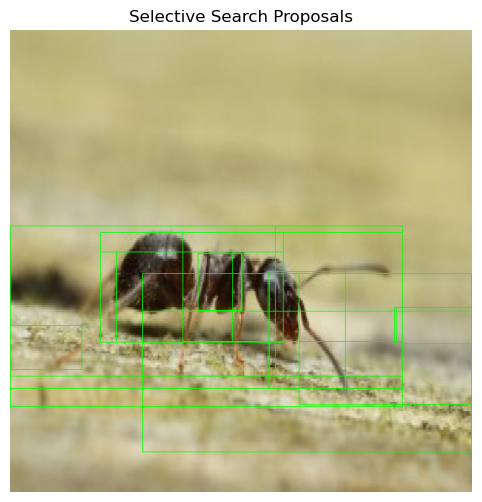

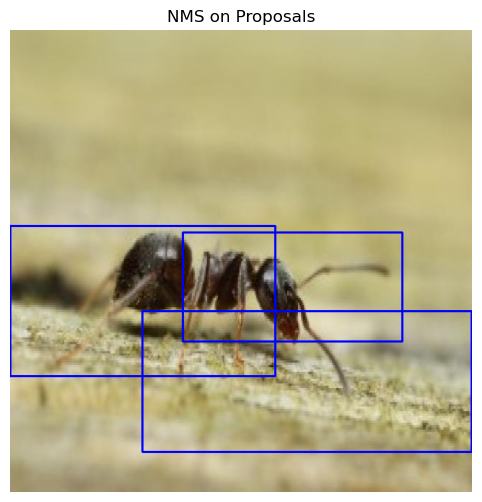

In [33]:
model_data = joblib.load("rf_model_insect.pkl")
rf_model = model_data["model"]
scaler = model_data["scaler"]
class_names = model_data["class_names"]
result1 = detect_image_rf('ants-455-_jpg.rf.ef4e908c79575f5e0d089d71e471a18a.jpg', rf_model, scaler, class_names,
                    show_plots=True, show_grams=True, nms_iou_thresh=0.3, IoU_THRESHOLD=0.5)

Predicted class: Caterpillars (prob: 0.265000)


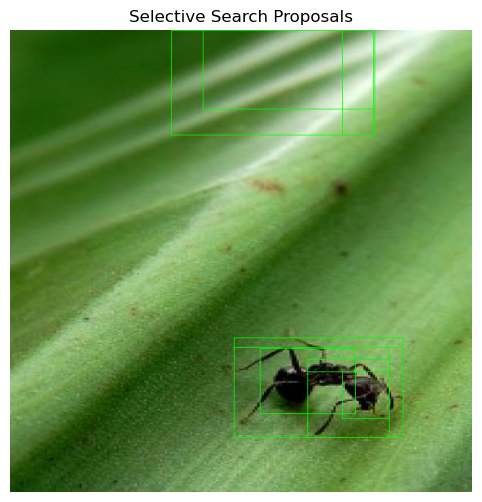

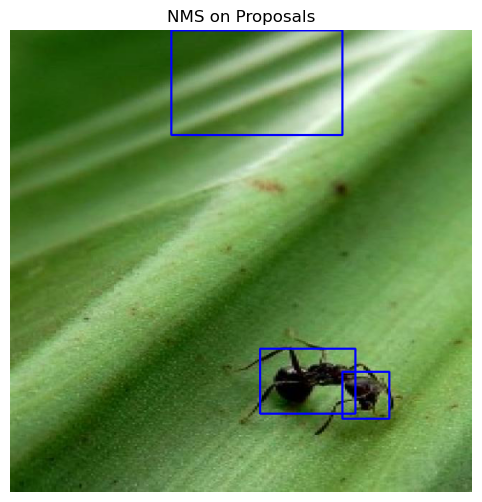

In [35]:
model_data = joblib.load("rf_model_insect.pkl")
rf_model = model_data["model"]
scaler = model_data["scaler"]
class_names = model_data["class_names"]
result1 = detect_image_rf('ants-74-_jpg.rf.8f2e4ecbb67a8cd1e600e7ca34f4d3bf.jpg', rf_model, scaler, class_names,
                    show_plots=True, show_grams=True, nms_iou_thresh=0.3, IoU_THRESHOLD=0.5)